In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
torch.cuda.set_device(0)
from pathlib import Path
torch.cuda.set_device(0)

In [3]:
MASKS = 'train.csv'
SUB = 'sample_submission.csv'
TRAIN64 = Path('train64/')
TRAIN128 = Path('train128/')
TEST = Path('test/')
PATH = Path('HPA/')
TMP = Path('tmp/')
MODEL = Path('model/')

seg = pd.read_csv(PATH/MASKS).set_index('Id')
# sample_sub = pd.read_csv(PATH/SUB).set_index('Id')

sample= 31072

seg2 = seg.iloc[0:sample]
val_idxs = get_cv_idxs(sample)

seg.head()

,Target
Id,
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [4]:
train_names_png = [TRAIN64/f for f in os.listdir(PATH/TRAIN64)]
train_names = list(seg.index.values)
train_names_sample = list(seg.index.values)[0:sample]
# test_names_png = [TEST/f for f in os.listdir(PATH/TEST)]
# test_names = list(sample_sub.index.values)
# test_names_sample = list(sample_sub.index.values)[0:sample]
len(train_names_sample), #len(test_names)

(31072,)

In [5]:
TMP.mkdir(exist_ok=True)
MODEL.mkdir(exist_ok=True)

In [6]:
def rgba_open(fname, path=PATH, sz=128):
    '''open RGBA image from 4 different 1-channel files.
    return: numpy array [4, sz, sz]'''
    flags = cv2.IMREAD_GRAYSCALE
    red = cv2.imread(str(path/(fname+ '_red.png')), flags)
    blue = cv2.imread(str(path/(fname+ '_blue.png')), flags)
    green = cv2.imread(str(path/(fname+ '_green.png')), flags)
    yellow = cv2.imread(str(path/(fname+ '_yellow.png')),flags)
    im = np.array([red, green, blue, yellow], dtype=np.float32)
    rgba = cv2.resize(np.rollaxis(im, 0,3), (sz, sz), interpolation = cv2.INTER_CUBIC)
    return np.rollaxis(rgba, 2,0)/255

def rgba_open2(fname, path=PATH, sz=128):
    '''open RGBA image from 1 4-channel image.
    return: numpy array [4, sz, sz]'''
    flags = cv2.IMREAD_UNCHANGED
    rgba = cv2.imread(str(path/(fname+ '.png')),flags)/255
    return rgba #np.rollaxis(rgba, 2,0)

In [7]:
train_names[1]

'000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0'

In [8]:
%time im = rgba_open2(train_names[1], PATH/TRAIN64); im.shape

CPU times: user 672 µs, sys: 211 µs, total: 883 µs
Wall time: 525 µs


In [9]:
class CustomDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path, sz):
        self.y=y
        self.fnames = fnames
        self.sz = sz
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
        
    def get_x(self, i): 
        return rgba_open2(self.fnames[i], self.path, self.sz)
        
    def get_y(self, i):
        return self.y[i]
    def get_sz(self): return self.sz
    def get_c(self): return 28
    @property
    def is_multi(self):
        return True

In [10]:
indexes = seg2.Target.apply(str.split)
y = np.zeros((sample, 28))
for i in range(sample):
    y[i,np.array(indexes[i], dtype=int)]=1

In [11]:
len(train_names_sample),  y.shape, y.dtype

(31072, (31072, 28), dtype('float64'))

In [12]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(train_names_sample), y)

In [31]:
# tfms = tfms_from_model(resnet34, sz=sz, crop_type=CropType.NO, aug_tfms=[])
def get_data(sz=64, bs=32, aug=False):
    if aug:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                    RandomDihedral(tfm_y=TfmType.NO),
                    RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    else: 
        aug_tfms = []
    #mean and std in of each channel in the train set
    stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    if sz==64:
        datasets = ImageData.get_ds(CustomDataset, (trn_x,trn_y), (val_x,val_y), sz=sz, tfms=tfms, path=PATH/TRAIN64)
    if sz==128:
        datasets = ImageData.get_ds(CustomDataset, (trn_x,trn_y), (val_x,val_y), sz=sz, tfms=tfms, path=PATH/TRAIN128)
    if sz==256:
        datasets = ImageData.get_ds(CustomDataset, (trn_x,trn_y), (val_x,val_y), sz=sz, tfms=tfms, path=PATH/TRAIN256)
        datasets[4] = CustomDataset(test_names, test_names, tfms[0], PATH/TEST, sz)
    return ImageData(PATH, datasets, bs=bs, num_workers=4, classes=28)

In [44]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastai.layers import *

def conv_2d(ni, nf, ks, stride): return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn(ni, init_zero=False):
    m = nn.BatchNorm2d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_relu_conv(ni, nf, ks, stride, init_zero=False):
    bn_initzero = bn(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv_2d(ni, nf, ks, stride))

def noop(x): return x

class BasicBlock(nn.Module):
    def __init__(self, ni, nf, stride, drop_p=0.0):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 3, stride)
        self.conv2 = bn_relu_conv(nf, nf, 3, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv_2d(ni, nf, 1, stride) if ni != nf else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)


def _make_group(N, ni, nf, block, stride, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1, drop_p) for i in range(N)]

class WideResNet(nn.Module):
    def __init__(self, num_groups, N, num_classes, k=1, drop_p=0.0, start_nf=16):
        super().__init__()
        n_channels = [start_nf]
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)

        layers = [conv_2d(4, n_channels[0], 3, 1)]  # conv1
        for i in range(num_groups):
            layers += _make_group(N, n_channels[i], n_channels[i+1], BasicBlock, (1 if i==0 else 2), drop_p)

        layers += [nn.BatchNorm2d(n_channels[3]), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d(1),
                   Flatten(), nn.Linear(n_channels[3], num_classes)]
#         layers += [nn.Sigmoid()]
        self.features = nn.Sequential(*layers)

    def forward(self, x): return self.features(x)


def wrn_22(): return WideResNet(num_groups=3, N=3, num_classes=28, k=6, drop_p=0.1)

In [45]:
# m = Darknet([1,2,4], 28)
m = wrn_22()

In [46]:
from sklearn.metrics import fbeta_score
import warnings

def f1_(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 1, average='samples')
                    for th in np.arange(start,end,step)])

In [48]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    


def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [49]:
md = get_data(sz=64, bs=128)

In [50]:
learn = ConvLearner.from_model_data(m, md, tmp_name=TMP, models_name=MODEL)
learn.crit = FocalLoss()#nn.BCEWithLogitsLoss()
learn.opt_fn = optim.Adam
learn.metrics = [f1_, acc]

 89%|████████▉ | 174/195 [01:41<00:12,  1.71it/s, loss=7.56]

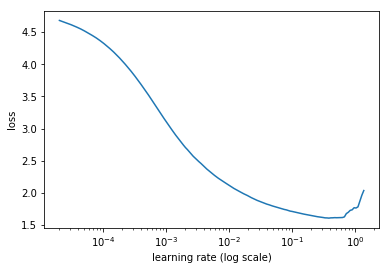

In [51]:
learn.lr_find()
learn.sched.plot()

In [52]:
# lr = 1e-2 #darknet
lr = 1e-2

wd=1e-5

In [53]:
%time learn.fit(lr,1,cycle_len=6, use_clr_beta=(10, 10, 0.85, 0.9))

epoch      trn_loss   val_loss   f1_        acc             
    0      1.229063   1.463405   0.18218    0.931951  
    1      1.186539   1.334655   0.250601   0.948854        
    2      1.119723   1.204033   0.299968   0.946739        
    3      1.056073   1.137824   0.323967   0.951486        
    4      1.004204   1.113901   0.34352    0.951963         
    5      0.959218   1.097033   0.398992   0.952636         
CPU times: user 9min, sys: 4min 58s, total: 13min 59s
Wall time: 12min 15s


[1.0970331773061173, 0.39899152451453707, 0.9526357974198841]

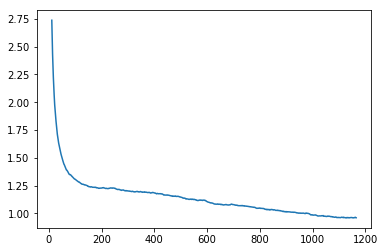

In [54]:
learn.sched.plot_loss()

In [55]:
learn.save('wrn_64')

In [56]:
learn.load('wrn_64')

In [57]:
learn.set_data(get_data(128, 32))

In [ ]:
learn.fit(lr/4,4,cycle_len=2,use_clr=(10,20))

epoch      trn_loss   val_loss   f1_        acc              
    0      0.961124   1.139271   0.390393   0.951756  
    1      0.898399   1.273104   0.420079   0.946607         
    2      0.886908   1.176329   0.494099   0.952113         
 51%|█████     | 393/777 [03:35<03:30,  1.83it/s, loss=0.86] 

In [ ]:
learn.sched.plot_lr()

In [44]:
learn.save('wrn_128')

In [36]:
pwd

'/notebooks'

In [ ]:
preds = learn.predict(is_test=True)

In [ ]:
threshold = 0.17
print(preds.shape)
classes = np.array([str(n) for n in range(28)])
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

In [ ]:
filenames = np.array([os.path.basename(fn).split('.')[0] for fn in test_names])

In [ ]:
res.shape, filenames.shape

In [ ]:
frame = pd.DataFrame(np.array([filenames, res]).T, columns = ['Id','Predicted'])

In [ ]:
frame.head()

In [ ]:
frame.to_csv('submission.csv', index=False)